In [1]:
from pathlib import Path
import json
import re
from tqdm import tqdm
import sys
from multiprocessing import Pool

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use("default")
WORK_DIR = Path().absolute()
sys.path.append(str(WORK_DIR.parent))

In [2]:
from energyvslatconst import energyvslatconst

In [3]:
# Read settings
ROOT_DIR = WORK_DIR.parent
SETTINGS_DIR = ROOT_DIR / "settings"

settings_path = SETTINGS_DIR / "settings0.json"
with open(settings_path, "r") as f:
    settings = json.load(f)

RES_DIR = WORK_DIR / "results" / re.match(r"^[^_\.]+", settings_path.name).group()
if not RES_DIR.exists():
    RES_DIR.mkdir(parents=True)
PLOT_DIR = RES_DIR / "plots"
if not PLOT_DIR.exists():
    PLOT_DIR.mkdir(parents=True)

In [4]:
##########################################################################################
# Dropout
# -------
# Compute the energy ensembles
potential = "DUNN_best_train"
ainit = 2.466
alist = np.linspace(0.93, 1.09, 21) * ainit
preds_samples_file = RES_DIR / "uncertainty_energy_vs_latconst_graphite.npz"
if preds_samples_file.exists():
    preds_data = np.load(preds_samples_file)
    energy_ensembles = preds_data["energy_ensembles"]
    latconst_ensembles = preds_data["latconst_ensembles"]
else:
    # Use multiprocessing to speed up the calculation
    def energyvslatconst_wrapper(set_idx):
        elist = energyvslatconst(potential, alist, "graphite", set_idx + 1)
        return elist

    with Pool(25) as p:
        energy_latconst_ensembles = list(
            tqdm(p.imap(energyvslatconst_wrapper, range(100)), total=100)
        )

    energy_latconst_ensembles = np.array(energy_latconst_ensembles).astype(float)
    energy_latconst_mean_do = np.mean(energy_latconst_ensembles, axis=0)
    energy_latconst_error_do = np.std(energy_latconst_ensembles, axis=0)
    np.savez(
        preds_samples_file,
        alist=alist,
        energy_ensembles=energy_latconst_ensembles[:, 1],
        latconst_ensembles=energy_latconst_ensembles[:, 2],
    )

In [5]:
energy_mean_do = np.mean(energy_ensembles, axis=0)
energy_error_do = np.std(energy_ensembles, axis=0)

latconst_mean_do = np.mean(latconst_ensembles, axis=0)
latconst_error_do = np.std(latconst_ensembles, axis=0)

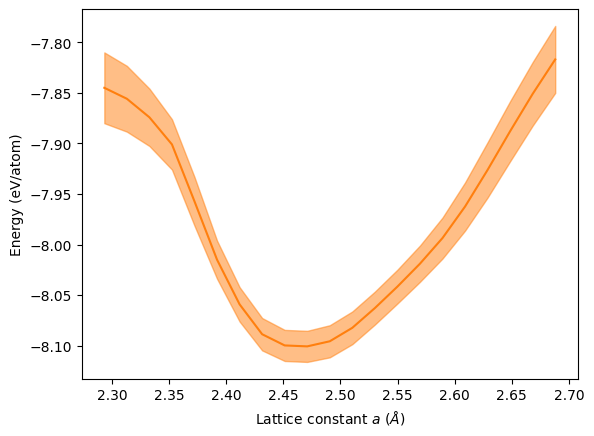

In [6]:
# Plot the result curves
# Energy vs lattice constant
plt.figure()

# Dropout
plt.fill_between(
    alist,
    energy_mean_do - energy_error_do,
    energy_mean_do + energy_error_do,
    alpha=0.5,
    color="tab:orange",
)
plt.plot(alist, energy_mean_do, "-", color="tab:orange", label="DUNN dropout")
# plt.ylim(-8.12, -7.25)
plt.xlabel(r"Lattice constant $a$ $(\AA)$")
plt.ylabel("Energy (eV/atom)")

plt.show()

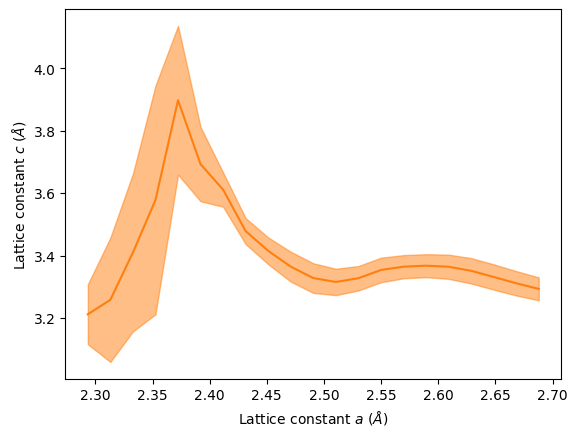

In [7]:
# Plot the result curves
# latconst vs lattice constant
plt.figure()

# Dropout
plt.fill_between(
    alist,
    latconst_mean_do - latconst_error_do,
    latconst_mean_do + latconst_error_do,
    alpha=0.5,
    color="tab:orange",
)
plt.plot(alist, latconst_mean_do, "-", color="tab:orange", label="DUNN dropout")
# plt.ylim(-8.12, -7.25)
plt.xlabel(r"Lattice constant $a$ $(\AA)$")
plt.ylabel(r"Lattice constant $c$ $(\AA)$")

plt.show()